# **Tracking CZU Lightning Complex Fire Using Satellite Raster Analysis**

By Nathan Gorton (nsg57)


## **Introduction**

On August 16, 2020, a historic lightning storm caused hundreds of wildfires to start in California. One such fire, The CZU Lightning Complex Fire, started as the combination of multiple lightning caused wildfires in San Mateo and Santa Cruz counties. From emergence to containment, this fire ravaged for 38 days (August 16th - September 22nd), and, in total 1,490 buildings were destroyed and 35,009 hectares of land were burned. Given the high levels of devastation seen from this fire, which were not seen from previous fires in this area, it is important to have an understanding of the factors that lead to the spread of this fire, as well as how the fires affected the area, which can help inform future wildfire containment efforts. Specifically, this analysis will be looking at relationships between burned land, human development, and vegetation levels. Overall, it is suggested that in this area, areas that are more developed and areas that have less vegetation are less likely to be burned in wildfires.

## **Table of Contents**
1. [Data Description](#data-desc)
2. [Data Limitations](#data-lim)
3. [Preregistration Statement](#preregistration)
4. [Data Collection And Cleaning](#data-collect-clean)
    - [Data Collection](#collect)
    - [Data Cleaning](#clean)
5. [Data Analysis](#dat-analysis)
    - [Summary Statistics](#sum-stats)
    - [Analysis](#analysis)
6. [Evaluation of Significance](#sig)
7. [Conclusions](#con)
8. [Limitations](#lim)
9. [References](#ref)
 
## **Data Description** <a class="anchor" id="data-desc"></a>

Raster data consists of two dimensional matrices containing values for each pixel. Satellite raster datasets are imagery of the Earth which contain multiple rasters representing visible and non-visible parts of the electromagnetic spectrum. This is referred to as multi-spectrum imagery. The satellite raster datasets used for this analysis are from the Sentinel-2 mission, specifically from the Sentinel-2A satellite. The Sentinel-2 mission is an Earth Observation mission from the Copernicus program which is funded by the European Space Agency (ESA). These Raster tile datasets are calculated every ten days.

The pre-processed dataset which is utilized in this analysis is comprised of satellite raster datasets which contain multiple different rasters that represent satellite images taken. The dataset is comprised of six of these satellite raster datasets which are satellite imagery taken from the Sentinel-2A satellite from 8/12/2020 - 10/01/2020. The satellite imagery is of the San Francisco Bay Area in California, as well as various other counties near by. This area is contained in the ```T10SEG``` tile from the Sentinel-2A satellite. To collect this data, [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) is used.

The processed data in the dataset consists of various indices calculated using satellite imagery rasters. These indices are: NDVI (Normalized Difference Vegetation Index), NDBI (Normalized Difference Built-Up Index), NBR (Normalized Burn Ratio). These indices are in the form of rasters which are saved as GeoTiff files. This allows one to get a corresponding score from each index for any geographic location. 

## **Data Limitations** <a class="anchor" id="data-lim"></a>

The primary limitation of this dataset has to do with the intervals that the satellite imagery is taken. Each of the satellite raster datasets is only calculated once every 10 days, which means it is harder to see how the fire is spreading. While it would be useful to access high resolution satellite imagery calculated every day, the only programs that do this are either classified or are expensive to access, and the only free options of daily satellite imagery are low resolution imagery (ie NOAA Satellites). When choosing which data source to use I could only choose two out of the three ideal categories: High Resolution, Free, and Calculated Daily. Since High Resolution imagery was needed to properly calculate the specific indices that I used, the Sentinel-2 mission was the ideal choice since it was free.

Another big limitation is the satellite raster datasets from the Sentinel-2 mission do not contain thermal imagery data, which means surface temperatures cannot be calculated. This effectively gatekeeps certain useful analyses from being performed. Additionally, given the Sentinel-2 mission is fairly new, it does not contain imagery data from other fires in the area, meaning there is nothing to compare it to besides before and after this specific fire fire in this area.

## **Preregistration Statement** <a class="anchor" id="preregistration"></a>

In this analysis, the following two things will be analyzed:
 1. If there is a correlation between burned land and build-up areas
 2. If there is a correlation between burned land and vegetation

## **Data Collection And Cleaning** <a class="anchor" id="data-collect-clean"></a>

### **Data Collection** <a class="anchor" id="collect"></a>

The CZU Lightning Complex Fire started August 16, 2020 and was fully contained 9/22/2020. For purposes of fire tracking, the datasets should include rasters from prefire to postfire. Six datasets are utilized, containing raster data from 8/12/2020 to 10/01/2020.

To collect satellite raster datasets, the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) is used. Using the graphical user interface, the settings in the advanced options menu shown below are selected.

![title](Img/scihubadvancedoptions.png)

The ```T10SEG``` tile is then selected, given it contains rasters for the area affected by the CZU Lightning Complex fire, and specific datasets are filtered for using the search menu.

![title](Img/highlightandselect.png)

The satellite raster datasets are then retrieved and listed in order from newest date to oldest date. The ```T10SEG``` raster datasets for 8/12/2020, 8/22/2020, 9/01/2020, 9/11/2020, 9/22/2020, 10/01/2020 are selected and downloaded. They are then extracted to the dataset folder to be processed.

### **Data Cleaning** <a class="anchor" id="clean"></a>

Import the necessary libraries to perform geospatial analysis

In [33]:
import rasterio as rio
from rasterio.plot import show
import pandas as pd
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import json
import pycrs

Run ```gdalinfo``` on the file ```MTD_MSIL2A.xml``` in each dataset to extract the path for each specific subdataset. Use ```rasterio.open``` , with the ```path``` locations given from running ```gdalinfo```, to open each subdataset in python

In [3]:
# Load each subdataset into a DatasetReader object
first_dataset = rio.open("SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200812T184921_N0214_R113_T10SEG_20200812T230948.SAFE/MTD_MSIL2A.xml:TCI:EPSG_32610")
second_dataset = rio.open("SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200822T184921_N0214_R113_T10SEG_20200822T230935.SAFE/MTD_MSIL2A.xml:TCI:EPSG_32610")
third_dataset =rio.open("SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200901T184921_N0214_R113_T10SEG_20200901T231711.SAFE/MTD_MSIL2A.xml:TCI:EPSG_32610")
fourth_dataset = rio.open("SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200911T184951_N0214_R113_T10SEG_20200911T230706.SAFE/MTD_MSIL2A.xml:TCI:EPSG_32610")
fifth_dataset = rio.open("SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200921T185101_N0214_R113_T10SEG_20200921T231937.SAFE/MTD_MSIL2A.xml:TCI:EPSG_32610")
sixth_dataset = rio.open("SENTINEL2_L2A:Dataset/S2A_MSIL2A_20201001T185221_N0214_R113_T10SEG_20201001T225950.SAFE/MTD_MSIL2A.xml:TCI:EPSG_32610")

Now each subdataset is parsed into a ```DatasetReader``` object. ```DatasetReader``` objects can be read and parsed for data using ```numpy```, ```rasterio```, and ```matplotlib```. In this case the ```true color image``` subdatasets have been selected and opened, and can now be displayed using ```matplotlib``` and ```rasterio``` plotting functions

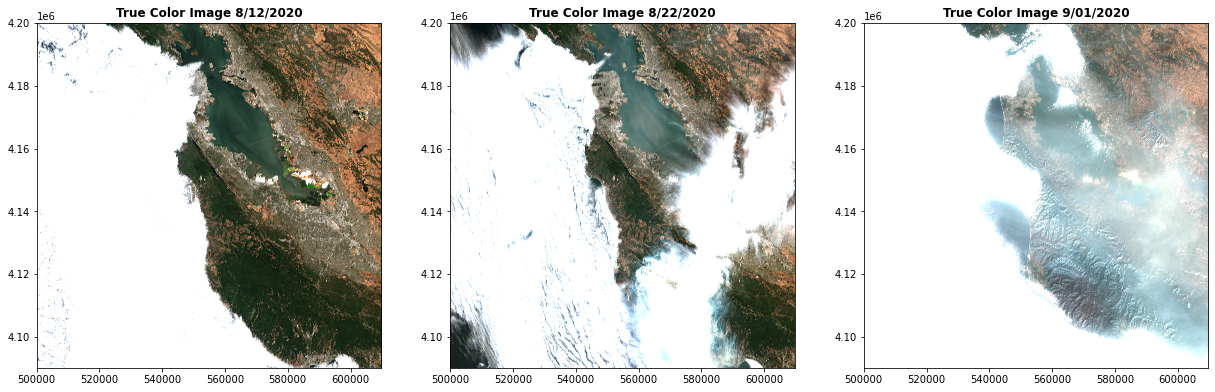

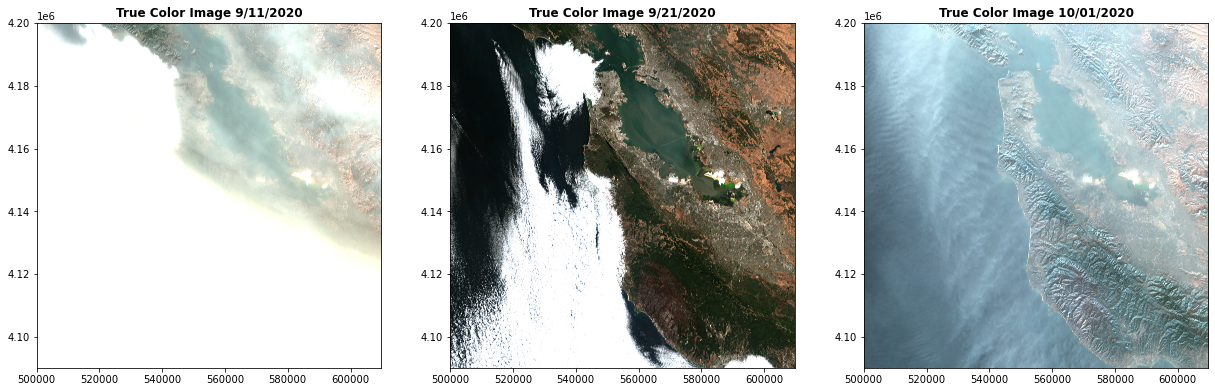

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,7))
show(first_dataset, ax=ax1, title='True Color Image 8/12/2020')
show(second_dataset, ax=ax2, title='True Color Image 8/22/2020')
show(third_dataset, ax=ax3, title='True Color Image 9/01/2020')
plt.show()
from shapely.geometry import box
fig2, (ax21, ax22, ax23) = plt.subplots(1, 3, figsize=(21,7))
show(fourth_dataset, ax=ax21, title='True Color Image 9/11/2020')
show(fifth_dataset, ax=ax22, title='True Color Image 9/21/2020')
show(sixth_dataset, ax=ax23, title='True Color Image 10/01/2020')
plt.show()

Now close each of the subdatasets

In [5]:
first_dataset.close()
second_dataset.close()
third_dataset.close()
fourth_dataset.close()
fifth_dataset.close()
sixth_dataset.close()

Now the data necessary to perform the analyses can be extracted from subdatasets. Save the path for each dataset's ```20m spatial resolution band``` subdataset to a variable for later use

In [6]:
ds_path_1 = "SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200812T184921_N0214_R113_T10SEG_20200812T230948.SAFE/MTD_MSIL2A.xml:20m:EPSG_32610"
ds_path_2 = "SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200822T184921_N0214_R113_T10SEG_20200822T230935.SAFE/MTD_MSIL2A.xml:20m:EPSG_32610"
ds_path_3 = "SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200901T184921_N0214_R113_T10SEG_20200901T231711.SAFE/MTD_MSIL2A.xml:20m:EPSG_32610"
ds_path_4 = "SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200911T184951_N0214_R113_T10SEG_20200911T230706.SAFE/MTD_MSIL2A.xml:20m:EPSG_32610"
ds_path_5 = "SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200921T185101_N0214_R113_T10SEG_20200921T231937.SAFE/MTD_MSIL2A.xml:20m:EPSG_32610"
ds_path_6 = "SENTINEL2_L2A:Dataset/S2A_MSIL2A_20201001T185221_N0214_R113_T10SEG_20201001T225950.SAFE/MTD_MSIL2A.xml:20m:EPSG_32610"

#### **Normalized Burn Ratio (NBR)**

Define a function to calculate the normalized burn ratio (NBR) and save the normalized burn ratio to a GeoTiff file for later use in the analyses. The normalized burn ratio is an index of the severity of burned areas in satellite imagery. The formula used to calculate the normalized burn ratio is a ratio between NIR (Near Infrared) and SWIR (Short Wave Infrared) bands. This formula is $NBR = \frac{NIR - SWIR}{NIR + SWIR}$, and for the ```20m spatial resolution band``` subdataset this is equivalent to $NBR = \frac{B8 - B12}{B8 + B12}$, where B8 is spectral band 8 and B12 is spectral band 12.

In [7]:
def normalized_burn_ratio(ds_path, output_img_name):
    
    # Read the subdataset into a DatasetReader object
    ds = rio.open(ds_path)
    
    # Read band 8 and band 12 from the subdataset into numpy arrays
    b8a = ds.read(4)
    b12 = ds.read(6)
    
    # Calculate a new numpy array containing the Normalized Burn Ratio for each pixel
    nbr=np.where(
        (b8a+b12)==0.,
        0,
        (b8a-b12)/(b8a+b12)
    )
    
    # Create a DatasetWriter object for a new output file and write the Normalized Burn Ratio array into it
    nbrImage = rio.open('Output/' + output_img_name,'w',driver='Gtiff',
                    width=ds.width, height=ds.height,
                     count=1,
                     crs=ds.crs,
                     transform=ds.transform,
                     dtype='float64'
                    )

    nbrImage.write(nbr, 1)
    
    # Close the DatasetWriter
    nbrImage.close() 

Apply ```normalized_burn_ratio``` function to each subdataset

In [8]:
normalized_burn_ratio(ds_path_1, 'nbr_0812.tiff')
normalized_burn_ratio(ds_path_2, 'nbr_0822.tiff')
normalized_burn_ratio(ds_path_3, 'nbr_0901.tiff')
normalized_burn_ratio(ds_path_4, 'nbr_0911.tiff')
normalized_burn_ratio(ds_path_5, 'nbr_0921.tiff')
normalized_burn_ratio(ds_path_6, 'nbr_1001.tiff')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


The Normalized Burn Ratio for each subdataset is now calculated and saved to GeoTiff files. Now we want to crop each NBR to only contain the areas affected by the fire, and save it to a GeoTiff file. Define a function ```crop_raster``` which uses ```shapely``` to crop the rasters, and uses wgs84 coordinates to find the cropped selection.

In [9]:
def crop_raster(filename, output, minx, miny, maxx, maxy):
    
    data = rio.open(filename)
    
    bbox = box(minx, miny, maxx, maxy)
    
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    
    geo = geo.to_crs(crs=data.crs.data)
    
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
    
    out_meta = data.meta.copy()
    
    epsg_code = int(data.crs.data['init'][5:])
    
    out_meta.update({"driver": "GTiff",
                    "height": out_img.shape[1],
                    "width": out_img.shape[2],
                    "transform": out_transform,
                    "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                       )
    
    with rio.open('Output/' + output, "w", **out_meta) as dest:
        dest.write(out_img)

Apply ```crop_raster``` to each NBR raster file

In [10]:
crop_raster('Output/nbr_0812.tiff', 'nbr_0812_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)
crop_raster('Output/nbr_0822.tiff', 'nbr_0822_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)
crop_raster('Output/nbr_0901.tiff', 'nbr_0901_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)
crop_raster('Output/nbr_0911.tiff', 'nbr_0911_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)
crop_raster('Output/nbr_0921.tiff', 'nbr_0921_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)
crop_raster('Output/nbr_1001.tiff', 'nbr_1001_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

Now that the rasters have been cropped, extreme values must be filtered. Define a function ```filter_extremes```, which uses ```numpy``` to filter out extremes in each raster matrix based on a minimum and a maximum

In [11]:
def filter_extremes(nbr_array, min_k, max_k):
    
    nbr_array_max_filtered = np.where(
        nbr_array <= max_k, 
        nbr_array,
        0
    )
    
    nbr_array_extremes_filtered = np.where(
        nbr_array_max_filtered >= min_k, 
        nbr_array_max_filtered,
        0
    )
    
    return nbr_array_extremes_filtered

Now apply ```filtered_extremes``` to each cropped raster, using -1 to 1 as the valid range of values, given -1 to 1 is the range of valid values for the NBR 

In [12]:
# Open each NBR GeoTiff  using rasterio and save to a DatasetReader object
first_nbr = rio.open('Output/nbr_0812_cropped.tiff')
second_nbr = rio.open('Output/nbr_0822_cropped.tiff')
third_nbr = rio.open('Output/nbr_0901_cropped.tiff')
fourth_nbr = rio.open('Output/nbr_0911_cropped.tiff')
fifth_nbr = rio.open('Output/nbr_0921_cropped.tiff')
sixth_nbr = rio.open('Output/nbr_1001_cropped.tiff')

# Define min and max values for range
min_k = -1.
max_k = 1.

# Read into a numpy array and apply filter_extremes
filter_first_nbr = filter_extremes(first_nbr.read(), min_k, max_k)
filter_second_nbr = filter_extremes(second_nbr.read(), min_k, max_k)
filter_third_nbr = filter_extremes(third_nbr.read(), min_k, max_k)
filter_fourth_nbr = filter_extremes(fourth_nbr.read(), min_k, max_k)
filter_fifth_nbr = filter_extremes(fifth_nbr.read(), min_k, max_k)
filter_sixth_nbr = filter_extremes(sixth_nbr.read(), min_k, max_k)

Now display each of the filtered NBR's using ```matplotlib``` and ```rasterio```

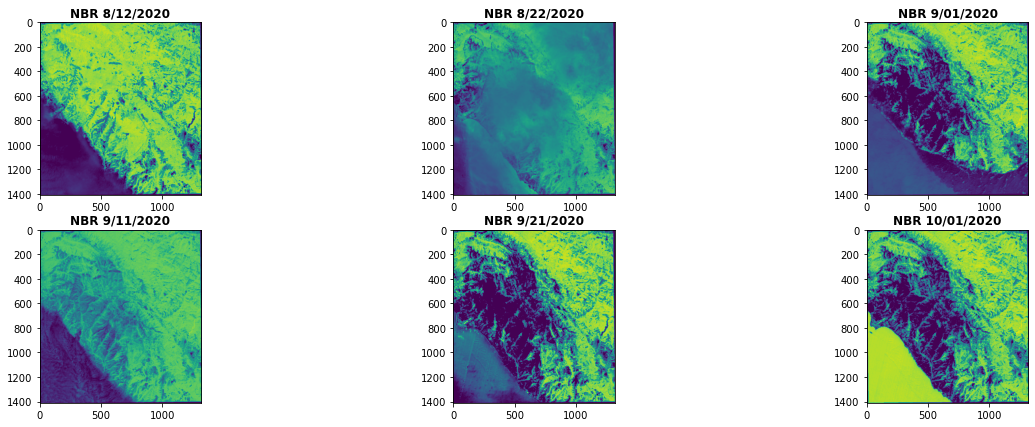

In [13]:
# Use matplotlib and rasterio to display all of the NBR files
fig, axs = plt.subplots(2, 3, figsize=(21,7))
show(filter_first_nbr, ax=axs[0, 0], title='NBR 8/12/2020', cmap='viridis')
show(filter_second_nbr, ax=axs[0, 1], title='NBR 8/22/2020', cmap='viridis')
show(filter_third_nbr, ax=axs[0, 2], title='NBR 9/01/2020', cmap='viridis')
show(filter_fourth_nbr, ax=axs[1, 0], title='NBR 9/11/2020', cmap='viridis')
show(filter_fifth_nbr, ax=axs[1, 1], title='NBR 9/21/2020', cmap='viridis')
show(filter_sixth_nbr, ax=axs[1, 2], title='NBR 10/01/2020', cmap='viridis')
plt.show()

Now close each of the pre-filtered NBR GeoTiff files

In [14]:
first_nbr.close()
second_nbr.close()
third_nbr.close()
fourth_nbr.close()
fifth_nbr.close()
sixth_nbr.close()

The last step in making the NBR useful in our analysis is to calculate the dNBR. The dNBR is the difference in the prefire and post fire NBR's. The equation for this is $dNBR = prefireNBR - postfireNBR$. Define a function ```dNBR``` to calculate the dNBR

In [18]:
def dNBR(nbr_pre, nbr_post):
    return (nbr_pre - nbr_post)

Apply ```dNBR``` to each NBR using the NBR for 8/12/2020 as the $prefireNBR$

In [19]:
first_dNBR = dNBR(filter_first_nbr, filter_first_nbr)
second_dNBR = dNBR(filter_first_nbr, filter_second_nbr)
third_dNBR = dNBR(filter_first_nbr, filter_third_nbr)
fourth_dNBR = dNBR(filter_first_nbr, filter_fourth_nbr)
fifth_dNBR = dNBR(filter_first_nbr, filter_fifth_nbr)
sixth_dNBR = dNBR(filter_first_nbr, filter_sixth_nbr)

Display each dNBR using ```matplotlib``` and ```rasterio```

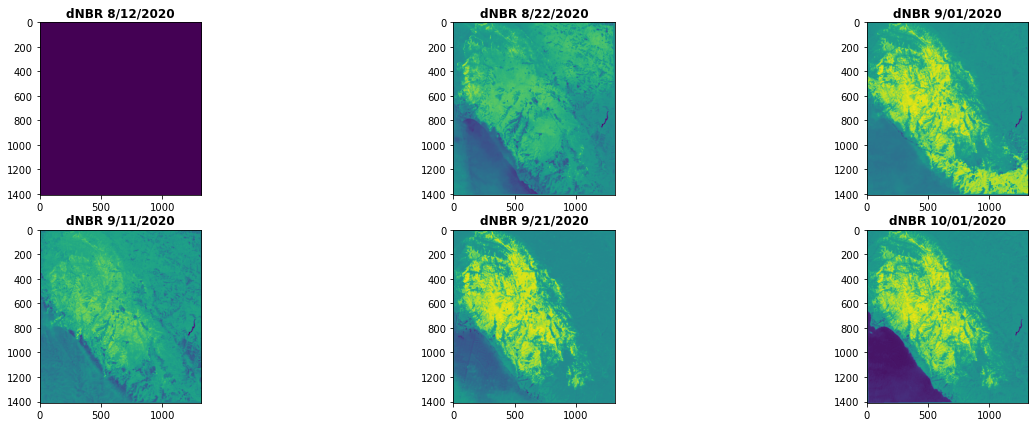

In [20]:
# Use matplotlib and rasterio to display all of the NBR files
fig, axs = plt.subplots(2, 3, figsize=(21,7))
show(first_dNBR, ax=axs[0, 0], title='dNBR 8/12/2020', cmap='viridis')
show(second_dNBR, ax=axs[0, 1], title='dNBR 8/22/2020', cmap='viridis')
show(third_dNBR, ax=axs[0, 2], title='dNBR 9/01/2020', cmap='viridis')
show(fourth_dNBR, ax=axs[1, 0], title='dNBR 9/11/2020', cmap='viridis')
show(fifth_dNBR, ax=axs[1, 1], title='dNBR 9/21/2020', cmap='viridis')
show(sixth_dNBR, ax=axs[1, 2], title='dNBR 10/01/2020', cmap='viridis')
plt.show()

A similar process to the NBR calculation can now be utilized to calculate the Normalized Difference Built-up Index and the Normalized Difference Vegetation Index. 

#### **Normalized Difference Built-up Index (NDBI)**

Define a function to calculate the normalized difference built-up index and save the normalized difference built-up index to a GeoTiff file for later use. The normalized difference build-up index is an index which is used to emphasize man-made built up areas. The formula used to calculate this index, like the normalized burn ratio, is a ratio between SWIR (Short Wave Infrared) and NIR (Near Infrared) bands. This formula is $NDBI = \frac{SWIR - NIR}{SWIR + NIR}$, and for the ```20m spatial resolution band``` subdataset this is equivalent to $NDBI = \frac{B11 - B8}{B11 + B8}$, where B8 is spectral band 8 and B11 is spectral band 11.

In [15]:
def normalized_difference_build_up_index(ds_path, output_img_name):
    
    # Read the subdataset into a DatasetReader object
    ds = rio.open(ds_path)
    
    # Read band 8 and band 11 from the subdataset into numpy arrays
    b8a = ds.read(4)
    b11 = ds.read(5)
    
    # Calculate a new numpy array containing the Normalized difference built up index for each pixel
    ndbi=np.where(
        (b8a+b11)==0.,
        0,
        (b11-b8a)/(b11+b8a)
    )
    
    # Create a DatasetWriter object for a new output file and write the Normalized difference built up index array into it
    ndbiImage = rio.open('Output/' + output_img_name,'w',driver='Gtiff',
                    width=ds.width, height=ds.height,
                     count=1,
                     crs=ds.crs,
                     transform=ds.transform,
                     dtype='float64'
                    )

    ndbiImage.write(ndbi, 1)
    
    # Close the DatasetWriter
    ndbiImage.close() 

Apply ```normalized_difference_built_up_index``` to the first subdataset since for analyses purposes it is only need to know how much built-up land existed before the fire

In [17]:
normalized_difference_build_up_index(ds_path_1, 'dnbi_0812.tiff')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Now crop using ```crop_raster``` and filter for extreme values using ```filter_extremes```. The valid range of values, like the NBR, is -1 to 1

In [21]:
crop_raster('Output/dnbi_0812.tiff', 'dnbi_0812_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)

dnbi = rio.open('Output/dnbi_0812_cropped.tiff')

min_k = -1.
max_k = 1.

filter_dnbi = filter_extremes(dnbi.read(), min_k, max_k)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Now display the cropped and filtered DNBI using ```matplotlib``` and ```rasterio```

In [22]:
show(filter_dnbi, title='DNBI', cmap='viridis')

Close the DNBI raster

In [23]:
dnbi.close()

#### **Normalized Difference Vegetation Index**

Define a function to calculate the normalized difference vegetation index and save the normalized difference vegetation index to a GeoTiff file for later use. The normalized difference vegetation index is an index which is used to represent different levels of vegetation. The formula used to calculate this index is a ratio between NIR (Near Infrared) and red light bands. Given the ```20m spatial resolution band``` does not contain a red light band, it is therefore necessary to use the ```10m spatial resolution band```. The formula for NDVI is $NDVI = \frac{NIR - RED}{NIR + RED}$, and for the ```10m spatial resolution band``` subdataset this is equivalent to $NDVI = \frac{B8 - B4}{B8 + B4}$, where B8 is spectral band 8 and B4 is spectral band 4.

In [16]:
def normalized_difference_vegetation_index(ds_path, output_img_name):
    
    # Read the subdataset into a DatasetReader object
    ds = rio.open(ds_path)
    
    # Read band 4 and band 8 from the subdataset into numpy arrays
    b4 = ds.read(3)
    b8a = ds.read(4)
    
    # Calculate a new numpy array containing the Normalized Difference Vegetation Index for each pixel
    ndbi=np.where(
        (b8a+b4)==0.,
        0,
        (b8a-b4)/(b8a+b4)
    )
    
    # Create a DatasetWriter object for a new output file and write the Normalized Difference Vegetation Index into it
    ndbiImage = rio.open('Output/' + output_img_name,'w',driver='Gtiff',
                    width=ds.width, height=ds.height,
                     count=1,
                     crs=ds.crs,
                     transform=ds.transform,
                     dtype='float64'
                    )

    ndbiImage.write(ndbi, 1)
    
    # Close the DatasetWriter
    ndbiImage.close() 

Now open the ```10m spatial resolution band``` for the first dataset and apply ```normalized_difference_vegetation_index```

In [47]:
ds_path_1_10m = "SENTINEL2_L2A:Dataset/S2A_MSIL2A_20200812T184921_N0214_R113_T10SEG_20200812T230948.SAFE/MTD_MSIL2A.xml:10m:EPSG_32610"

normalized_difference_vegetation_index(ds_path_1_10m, 'ndvi_0812.tiff')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Crop the raster using ```crop_raster``` 

In [48]:
min_k = -1.
max_k = 1.

crop_raster('Output/ndvi_0812.tiff', 'ndvi_0812_cropped.tiff', -122.34334,37.25725, -122.04950,37.00500)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


The final step to prepare the NDVI for analysis is to downsample it to a lower resolution. This is necessary given the NDVI was calculated using the ```10m spatial resolution band``` while the other two indices were calculated using the ```20m spatial resolution band```. Import the necessary libraries for downsampling

In [49]:
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

Define a function ```downsample``` to downsample from the ```10m spatial resolution band``` to the ```20m spatial resolution band```.

In [54]:
# downsample downsamples the raster to 1/2 the original resolution
def downsample(raster):
    
    # To downsample, a scale factor of 1/2 is used 
    scale = 1/2
    
    t = raster.transform

    # rescale the metadata
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = raster.height * scale
    width = raster.width * scale

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, int(height), int(width)),
            resampling=Resampling.nearest,
        )
    
    return data

Open the NDVI, apply ```downsample```, and Filter for extreme values using ```filter_extremes```. The valid range for NDVI, like the NBR and DNBI, is -1 to 1

In [60]:
ndvi = rio.open('Output/ndvi_0812_cropped.tiff')

ndvi_20m = filter_extremes(downsample(ndvi), -1, 1)

Now display the cropped and filtered NDVI using ```matplotlib``` and ```rasterio```

In [61]:
show(ndvi_20m, title='NDVI', cmap='viridis')

Now that the datasets have been parsed for the dNBR, NDBI, and NDVI indices, we can now move on to Data Analysis

## **Data Analysis** <a class="anchor" id="dat-analysis"></a>

### **Summary Statistics** <a class="anchor" id="sum-stats"></a>

To classify pixels from the dNBR's, there are different thesholds. Thresholds for different levels of burn severity are outlined below

![title](Img/dnbr_classification.png)

The dNBR's can be displayed as histograms to display how many pixels of each dNBR fall into each threshold. Use ```matplotlib``` and ```rasterio``` to display histograms for each dNBR

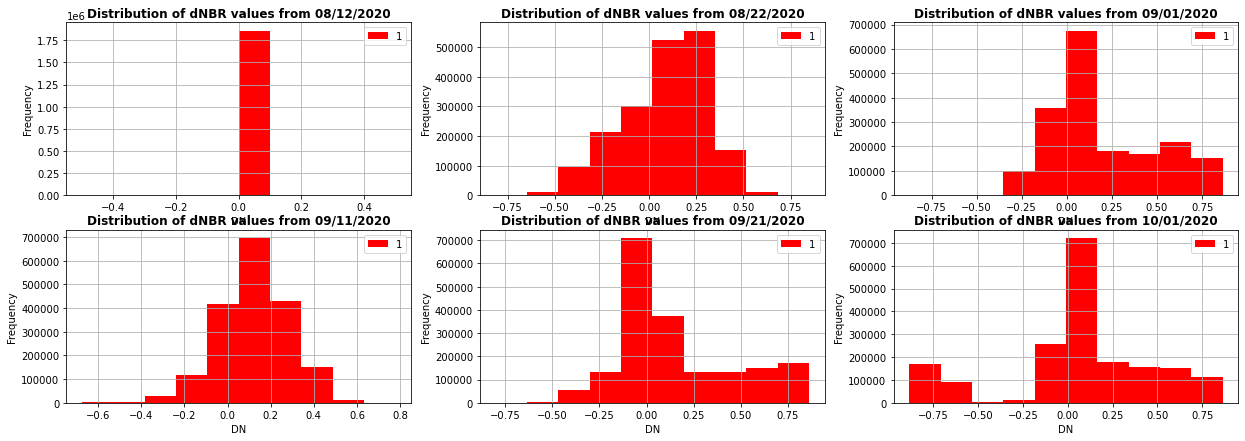

In [58]:
# Use matplotlib and rasterio to display all of the NBR files

fig, axs = plt.subplots(2, 3, figsize=(21,7))
rio.plot.show_hist(first_dNBR, ax=axs[0, 0], title="Distribution of dNBR values from 08/12/2020")
rio.plot.show_hist(second_dNBR, ax=axs[0, 1], title="Distribution of dNBR values from 08/22/2020")
rio.plot.show_hist(third_dNBR, ax=axs[0, 2], title="Distribution of dNBR values from 09/01/2020")
rio.plot.show_hist(fourth_dNBR, ax=axs[1, 0], title="Distribution of dNBR values from 09/11/2020")
rio.plot.show_hist(fifth_dNBR, ax=axs[1, 1], title="Distribution of dNBR values from 09/21/2020")
rio.plot.show_hist(sixth_dNBR, ax=axs[1, 2], title="Distribution of dNBR values from 10/01/2020")
plt.show()

Using the calculated dNBR's, the raster data can be classified to determine how much of the area has been burned. Define a function ```classify_as_burned``` to count the amount of burned pixels

In [62]:
# returns count of pixels 

def classify_as_burned(dNBR_array, burned_threshold):
    
    count = 0
    
    for x in dNBR_array:
        for y in x:
            if y > burned_threshold:
                count = count + 1
    
    return count

To classify each pixel as burned or unburned, the threshold used is .1. Apply ```classify_as_burned``` to each dNBR using .1 as the threshold

In [63]:
# Define burn threshhold value
burn_threshold = .1

first_burn_count = classify_as_burned(first_dNBR[0] , burn_threshold)
second_burn_count = classify_as_burned(second_dNBR[0] , burn_threshold)
third_burn_count = classify_as_burned(third_dNBR[0] , burn_threshold)
fourth_burn_count = classify_as_burned(fourth_dNBR[0] , burn_threshold)
fifth_burn_count = classify_as_burned(fifth_dNBR[0] , burn_threshold)
sixth_burn_count = classify_as_burned(sixth_dNBR[0] , burn_threshold)

Parse burn counts into a ```pandas``` dataframe

In [64]:
data = [['08/12/2020',first_burn_count],['08/22/2020',second_burn_count],['09/01/2020',third_burn_count],
        ['09/11/2020',fourth_burn_count],['09/21/2020',fifth_burn_count],['10/01/2020',sixth_burn_count]]
df= pd.DataFrame(data,columns=['Date','Burned_Pixels'])

Plot the burn counts

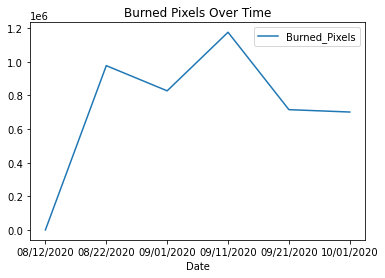

In [65]:
df.plot(x='Date',y='Burned_Pixels',title='Burned Pixels Over Time')

Applying a similar algorithm to the one used to calculate the total number of burned pixels, the counts of different burn severities can be calculated. Define a function ```classify_within_threshold```

In [66]:
# Returns the count

def classify_within_threshold(dNBR_array, min_t, max_t):
    
    count = 0
    
    for x in dNBR_array:
        for y in x:
            if (y <= max_t) and (y >= min_t):
                count = count + 1
    
    return count

Use ```classify_within_threshold``` to get pixel counts of different severity levels, and save it to a ```pandas``` dataframe

In [67]:
df1 = df.assign(regrowth = [classify_within_threshold(first_dNBR[0], -1, -.1), classify_within_threshold(second_dNBR[0], -1, -.1), classify_within_threshold(third_dNBR[0], -1, -.1), 
                           classify_within_threshold(fourth_dNBR[0], -1, -.1), classify_within_threshold(fifth_dNBR[0], -1, -.1), classify_within_threshold(sixth_dNBR[0], -1, -.1)]) 
df2 = df1.assign(unburned = [classify_within_threshold(first_dNBR[0], -.1, .1), classify_within_threshold(second_dNBR[0], -.1, .1), classify_within_threshold(third_dNBR[0], -.1, .1), 
                           classify_within_threshold(fourth_dNBR[0], -.1, .1), classify_within_threshold(fifth_dNBR[0], -.1, .1), classify_within_threshold(sixth_dNBR[0], -.1, .1)])  
df3 = df2.assign(low_severity = [classify_within_threshold(first_dNBR[0], .1, .27), classify_within_threshold(second_dNBR[0], .1, .27), classify_within_threshold(third_dNBR[0], .1, .27), 
                           classify_within_threshold(fourth_dNBR[0], .1, .27), classify_within_threshold(fifth_dNBR[0], .1, .27), classify_within_threshold(sixth_dNBR[0], .1, .27)])
df4 = df3.assign(medium_severity = [classify_within_threshold(first_dNBR[0], .27, .66), classify_within_threshold(second_dNBR[0], .27, .66), classify_within_threshold(third_dNBR[0], .27, .66), 
                           classify_within_threshold(fourth_dNBR[0], .27, .66), classify_within_threshold(fifth_dNBR[0], .27, .66), classify_within_threshold(sixth_dNBR[0], .27, .66)]) 
df5 = df4.assign(high_severity = [classify_within_threshold(first_dNBR[0], .66, 1), classify_within_threshold(second_dNBR[0], .66, 1), classify_within_threshold(third_dNBR[0], .66, 1), 
                           classify_within_threshold(fourth_dNBR[0], .66, 1), classify_within_threshold(fifth_dNBR[0], .66, 1), classify_within_threshold(sixth_dNBR[0], .66, 1)]) 

Display the updated dataframe

In [68]:
df5

Date  Burned_Pixels  regrowth  unburned  low_severity  \
0  08/12/2020              0         0   1859698             0   
1  08/22/2020         976974    379535    503189        546113   
2  09/01/2020         827266    280614    751821        212822   
3  09/11/2020        1175701    138983    545018        853465   
4  09/21/2020         715255    212642    931813        186780   
5  10/01/2020         701161    305026    853513        207084   

   medium_severity  high_severity  
0                0              0  
1           428994           1868  
2           416578         197873  
3           322187             49  
4           319508         208980  
5           353727         140359

Plot the pixel counts for each different burn severity

In [70]:
fig, axs = plt.subplots(2, 3, figsize=(21,7))
df5.plot(ax=axs[0, 0], x='Date',y='Burned_Pixels',title='Burned Pixels Over Time')
df5.plot(ax=axs[0, 1], x='Date',y='regrowth',title='Regrowth Pixels Over Time')
df5.plot(ax=axs[0, 2], x='Date',y='unburned',title='Unburned Pixels Over Time')
df5.plot(ax=axs[1, 0], x='Date',y='low_severity',title='Low Severity Pixels Over Time')
df5.plot(ax=axs[1, 1], x='Date',y='medium_severity',title='Medium Severity Pixels Over Time')
df5.plot(ax=axs[1, 2], x='Date',y='high_severity',title='High Pixels Over Time')
plt.show()

Looking at the graphs generated from the burn data, there seems to be general trends where the amount of burned pixels and the amount of regrowth pixels increases over the duration of the fire. However, there seems to be a drop in the amount of burned pixels at 10/01/2020. Now the hectares burned can be calculated. Since the spatial resolution of the dataset used is $400m^2$, or .04 hectares, the amount of hectares burned is equivalent to $amount_{burned pixels} * .04$. Calculate the amount of hectares burned and save as a column in the ```pandas``` dataframe

In [71]:
df_final = df5.assign(hectacres_burned = df5["Burned_Pixels"] * .04) 

Display the updated dataframe

In [73]:
df_final

Date  Burned_Pixels  regrowth  unburned  low_severity  \
0  08/12/2020              0         0   1859698             0   
1  08/22/2020         976974    379535    503189        546113   
2  09/01/2020         827266    280614    751821        212822   
3  09/11/2020        1175701    138983    545018        853465   
4  09/21/2020         715255    212642    931813        186780   
5  10/01/2020         701161    305026    853513        207084   

   medium_severity  high_severity  hectacres_burned  
0                0              0              0.00  
1           428994           1868          39078.96  
2           416578         197873          33090.64  
3           322187             49          47028.04  
4           319508         208980          28610.20  
5           353727         140359          28046.44

Looking at the summary statistics calculated and the official statistics reported via [Cal Fire](https://www.fire.ca.gov/incidents/2020/8/16/czu-lightning-complex-including-warnella-fire/), there seems to be a discrepancy as Cal Fire reported the fire as burning 35,009 hectares, whereas looking at the calculated interval closest to the end of the fire (09/21/2020), there only seems to be 28610 hectares burned. I am not entirely sure why this is exactly, however, looking at other statistics calculated from my dataset, there seems to be some more discrepancies and odd occurrences. For one, at 09/11/2020 the ```high_severity``` pixels drop to 49 from 197873. Additionally, as shown in the column ```hectacres_burned``` the amoount of hectares burned seems to drop off at the end of the fire below the amount of hectares burned in the beginning of the fire. I am not sure what is occurring here, however this could possibly suggest some limitations with using satellite imagery as a means to track fires, or even specifically the Sentinel-2 mission. Another valid possibility is that given the amount of regrowth increased over the duration fire, some of the burned land regrew. Given we don't know the exact methods that Cal Fire uses to calculate the amount of land burned in the fire or limitiations of satellite imagery systems, it would be hard to explore any of these possibilities. Nonetheless, the CZU Lightning Complex Fire has been quantified and tracked.

Moving onto the NDBI, the distribution of NDBI values can be displayed using ```matplotlib``` and ```rasterio```. Higher NDBI values correspond to more built-up areas.

In [75]:
rio.plot.show_hist(filter_dnbi, title="NDBI Values")

There isn't any specific classification for the NDBI as there is for the dNBR, however, values less than 0 are water and values from 0 to 1 represent how built up it is. As shown above, most of the land in the area affected by the fire is not built-up or sparsely built up

Moving onto the last calculated index, the NDVI can be classified as follows:
- NDVI = -1 to 0 represent Water bodies
- NDVI = -0.1 to 0.1 represent Barren rocks, sand, or snow
- NDVI = 0.2 to 0.5 represent Shrubs and grasslands or senescing crops
- NDVI = 0.6 to 1.0 represent Dense vegetation or tropical rainforest


The distribution of NDVI values can be displayed using ```matplotlib``` and ```rasterio```

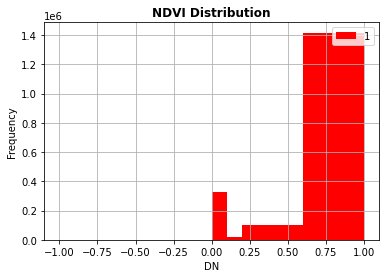

In [79]:
rio.plot.show_hist(ndvi_20m, bins=[-1, 0, .1, .2, .6, 1], lw=0.0, stacked=False, title="NDVI Distribution")

As can be seen, the majority of the area affected by the CZU Lightning Complex fire is dense vegetation, with some shrubs or grassland and some barren areas.

Now we can move onto analysis

### **Analysis** <a class="anchor" id="analysis"></a>

For this section, I will be analyzing whether human development and vegetation levels have any correlation with burned area to possibly determine if human developments and vegetation affect the spread of wildfires.

#### **Overlay Operation**

The first part of this will be carrying out an overlay operation. An overlay is the creation of a composite map of multiple datasets "overlayed" on one another. In this case, the ```dNBR``` rasters will be overlayed onto the ```NDBI``` raster and the ```NDVI``` raster. Define a function ```overlay_raster``` which will overlay one raster onto the second raster.

In [80]:
def overlay_raster(first_raster, second_raster):
    
    overlayed = np.ndarray(first_raster.shape, dtype=(float,2))
    
    for x in range(0, first_raster.shape[0]):
        for y in range(0, first_raster.shape[1]):
            overlayed[x][y] = [first_raster[x][y], second_raster[x][y]]
            
    return overlayed

For the purposes of this analysis, we are only concerned with using the last dNBR raster, as it encompasses the entire fire. Overlay the final ```dNBR``` raster from 10/01/2020 onto the ```NDBI``` and ```NDVI``` rasters

In [81]:
overlay_ndbi = overlay_raster(filter_dnbi[0], sixth_dNBR[0])
overlay_ndvi = overlay_raster(ndvi_20m[0], sixth_dNBR[0])

Now we have two overlayed rasters, one for ```NDBI``` and ```dNBR```, and another for ```NDVI``` and ```DNBR```. From this, flatten each overlayed raster. Define a function ```flatten_overlay```

In [82]:
def flatten_overlay(overlay):
    
    flattened = []
    
    for x in range(0, len(overlay)):
        for y in range(0, len(overlay[x])):
            flattened.append(overlay[x][y])
                       
    return flattened

Apply ```flatten_overlay``` to the overlays

In [83]:
flattened_overlay_ndbi = flatten_overlay(overlay_ndbi)
flattened_overlay_ndvi = flatten_overlay(overlay_ndvi)

#### **NDBI vs NBR Linear Regression**

From flattening the ```NDBI``` overlay we now have an array of points which each correspond to the same location giving us the ```NDBI``` and ```NBR``` scores. Using ```NDBI``` as the x-value and ```NBR``` as the y-value, regression analysis can now be performed. Import ```LinearRegression``` and ```train_test_split``` from ```sklearn```

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.feature_selection

Since this analysis is only looking at the burned areas from wildfires, the areas corresponding to water and the areas corresponding to regrowth will be filtered out

In [115]:
overlay_without_water = [(x, y) for x, y in flattened_overlay_ndbi if x > 0]
overlay_without_regrowth = [(x, y) for x, y in overlay_without_water if y >= -.1]

x_vals = [x for x, y in overlay_without_regrowth]
y_vals = [y for x, y in overlay_without_regrowth]

Split the data into train test split using ```sklearn```

In [116]:
X_train, X_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.25, random_state=42)

Create a ```LinearRegression``` object and fit training data

In [117]:
regr = LinearRegression()

regr.fit(np.reshape(X_train, (-1, 1)), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now use the calculated regression on the test data

In [118]:
y_pred = regr.predict(np.reshape(X_test, (-1, 1)))

fig, axs = plt.subplots(1, 1, figsize=(21,7))
axs.scatter(X_train, y_train, alpha=.06)
axs.plot(X_test, y_pred, color='red')
axs.set_xlabel("DNBI")
axs.set_ylabel("dNBR")
axs.set_title("dNBR vs DNBI")
fig.show()

From this we can see a negative correlation between NDBI and dNBR. That is, in laymans terms, the more "built-up" an area is, the less likely it is to be burned. While the pixels are scattered all over the place, the area with the highest density of pixels seems to be where the linear regression line runs through.

#### **NDVI vs NBR Linear Regression**

Like the first analysis, from flattening the ```NDVI``` overlay we now have an array of points which each correspond to the same location giving us the ```NDVI``` and ```NBR``` scores. Using ```NDVI``` as the x-value and ```NBR``` as the y-value, regression analysis can now be performed. First, filter out areas with regrowth and water

In [119]:
overlay_without_water = [(x, y) for x, y in flattened_overlay_ndvi if x > 0]
overlay_without_regrowth = [(x, y) for x, y in overlay_without_water if y >= -.1]

x_vals_ndvi = [x for x, y in overlay_without_regrowth]
y_vals_ndvi = [y for x, y in overlay_without_regrowth]

Split the data into train test split using ```sklearn```

In [120]:
X_train, X_test, y_train, y_test = train_test_split(x_vals_ndvi, y_vals_ndvi, test_size=0.25, random_state=42)

Create a ```LinearRegression``` object and fit training data

In [121]:
regr = LinearRegression()

regr.fit(np.reshape(X_train, (-1, 1)), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now use the calculated regression on the test data

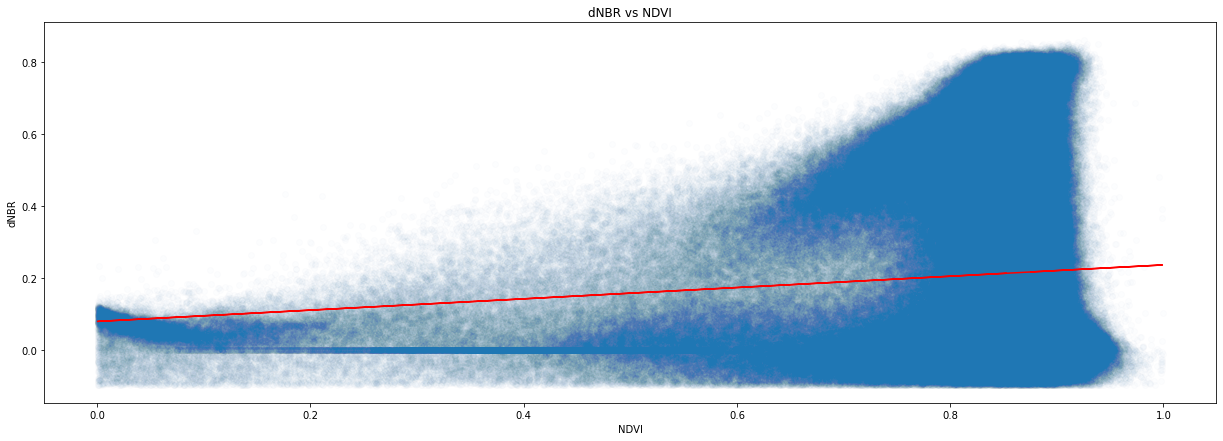

In [122]:
y_pred = regr.predict(np.reshape(X_test, (-1, 1)))

fig, axs = plt.subplots(1, 1, figsize=(21,7))
axs.scatter(X_train, y_train, alpha=.01)
axs.plot(X_test, y_pred, color='red')
axs.set_xlabel("NDVI")
axs.set_ylabel("dNBR")
axs.set_title("dNBR vs NDVI")
fig.show()

From this we can see a positive correlation between NDVI and dNBR. In laymans terms, this means the more vegetation an area has, the more likely it is to be burned in a wildfire.

## **Evaluation of significance** <a class="anchor" id="sig"></a>

To evaluate the significance of the regression analyses performed, ```statsmodels``` is used to implement hypothesis testing and analyze r-squared values

Use ```ordinary least squares``` to fit regressions for ```NDVI``` vs ```NBR``` and ```NDBI``` vs ```NBR```

In [169]:
mod1 = sm.OLS(y_vals, x_vals)
mod2 = sm.OLS(y_vals_ndvi, x_vals_ndvi)

fii = mod1.fit()
fii2 = mod2.fit()

Print statistics of ```NDBI``` vs ```NBR``` 

In [171]:
fii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.051
Method:                 Least Squares   F-statistic:                              4453.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        06:01:26   Log-Likelihood:                          88647.
No. Observations:               82051   AIC:                                 -1.773e+05
Df Residuals:                   82050   BIC:                                 -1.773e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1530      0.002     66.729      0.000       0.148       0.157
==============================================================================
Omnibus:                     5835.486   Durbin-Watson:                   0.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7159.272
Skew:                           0.717   Prob(JB):                         0.00
Kurtosis:                       3.195   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Print statistics of ```NDVI``` vs ```NBR```

In [172]:
fii2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.393
Model:                            OLS   Adj. R-squared (uncentered):              0.393
Method:                 Least Squares   F-statistic:                          9.789e+05
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        06:02:35   Log-Likelihood:                         -89189.
No. Observations:             1513266   AIC:                                  1.784e+05
Df Residuals:                 1513265   BIC:                                  1.784e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2512      0.000    989.370      0.000       0.251       0.252
==============================================================================
Omnibus:                   197265.600   Durbin-Watson:                   0.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           205466.981
Skew:                           0.844   Prob(JB):                         0.00
Kurtosis:                       2.361   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this, two things can be inferred. The first is that in both cases, the R-squared value is low, being .051 in the case of the ```NDBI``` vs ```NBR``` and being .393 in the case of the ```NDVI``` vs ```NBR```. This effectively means that this model can't *precisely* predict the output in either case. On the other hand, in both cases the P-Value is extremely low, which means we can be very statistically certain there is a trend.

## **Interpretations and Conclusions** <a class="anchor" id="con"></a>

The conclusion here is that as vegetation levels increase in the area affected by the CZU Lightning Fire, the likelihood of that land being burned in a wildfire increases. Additionally, as those areas becomes more developed, the likelihood of that area being burned in a wildfire decreases. However, given that the area affected by the CZU Lightning fire consist mostly of state parks and wilderness preserves, the development/deforestation of that land is impractical.

Therefore, what we can conclude is that fire-prevention methods which reduce the level of vegetation in this area will reduce the likelihood of wildfire spread. One such method which could be utilized is *controlled burning*, which is a fire-prevention method that involves the intentional starting of a fire to reduce the amount of leaf litter and dropped branches. Additionally, for private property owners, having a gardener could help reduce the likelihood of wildfire damage.

Nonetheless, this relationship should be explored more.

## **Limitations** <a class="anchor" id="lim"></a>

Ultimately, this study had three main different limitations. First of all, the dataset was limited, given that it focused on a very specific location over a short time period. This means this study was not a holistic look into all wildfires, but for breadth reasons I decided to limit the scope. The second limitation is the assumption that the various indices I utilized were accurate (NBR, NDBI, NDVI). Given the possibility that these indices are imperfect, any flaws from the origin of these indices are inherited into this study. The last limitation is that given I had no prior skill in geospatial analysis methods before this project, I could not perform more complex analyses.

## **References** <a class="anchor" id="ref"></a>

  - https://scihub.copernicus.eu/dhus/#/home
  - https://rasterio.readthedocs.io/en/latest/index.html
  - https://www.sciencedirect.com/science/article/pii/S0034425718305649
  - https://www.fire.ca.gov/incidents/2020/8/16/czu-lightning-complex-including-warnella-fire/
  - https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial
  - https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/calculate-dNBR-Landsat-8/
  - https://www.linkedin.com/pulse/ndvi-ndbi-ndwi-calculation-using-landsat-7-8-tek-bahadur-kshetri#:~:text=NDBI%20%3D%20(SWIR%20%E2%80%93%20NIR)%20%2F%20(SWIR%20%2B%20NIR)&text=Also%2C%20the%20Normalize%20Difference%20Build,value%20for%20vegetation%20is%20low.
  - https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLII-4-W9/165/2018/
  - https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLII-1-W2/43/2019/isprs-archives-XLII-1-W2-43-2019.pdf
  - https://custom-scripts.sentinel-hub.com/#sentinel-2
  - https://medium.com/@subarna.lamsal1/multiple-linear-regression-sklearn-and-statsmodels-798750747755
  - https://pandas.pydata.org/
  - https://www.statsmodels.org/stable/index.html